In [1]:
import utilidades
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
import geopandas as gpd
import pandas as pd
import datetime
import rasterio

In [ ]:
import multiprocessing
from multiprocessing import Pool
from time import time

In [2]:
os.chdir('/media/daniel/Respaldo/Memoria/Codigo/AraucoNursery/')
url_imagen = "PROYECTOS/CONTEO_SATELITE/imagenes/corte_pequeño_dron.tif"
rotados = "PROYECTOS/CONTEO_SATELITE/puntos_cortados.shp"

In [3]:
url_salida = "train/"+str(datetime.datetime.now().day)+"/"
url_salida_png = "train/"+str(datetime.datetime.now().day)+"/png/"
# url_salida_png_1 = "train/"+str(datetime.datetime.now().day)+"/png_1m/"
url_salida_tiff = "train/"+str(datetime.datetime.now().day)+"/tiff/"
url_salida_shp = "train/"+str(datetime.datetime.now().day)+"/shp/"
archivo_h5_cuentas = url_salida+'/data_cuentas.h5'
archivo_h5_mapa = url_salida+'/data_mapa.h5'

In [4]:
if not os.path.exists(url_salida):
    os.makedirs(url_salida)
if not os.path.exists(url_salida_png):
    os.makedirs(url_salida_png)
# if not os.path.exists(url_salida_png_1):
#     os.makedirs(url_salida_png_1)
if not os.path.exists(url_salida_tiff):
    os.makedirs(url_salida_tiff)
if not os.path.exists(url_salida_shp):
    os.makedirs(url_salida_shp)

In [5]:
# puntos = gpd.read_file(shp)
puntos = gpd.read_file(rotados)
raster = rasterio.open(url_imagen)

In [6]:
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    print(gt_count)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))

    print(pts.shape)
    leafsize = 2048
    # build kdtree
    print("build KDTREE")
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    print("query KDTREE")
    distances, locations = tree.query(pts, k=4)
    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [7]:
def get_coordenadas(raster, puntos, url_salida, nombre):
    print(url_salida + nombre + ".csv")
    """
    Dado un raster y un shapefile obtiene las posiciones de los puntos con respecto a x e y de la imagen.
    Genera un csv de la forma x, y (lat, lon)
    :raster: corresponde a una imagen tiff abierta con rasterio
    :puntos: Corresponde a un shapefile abierto en geopandas
    :url_salida: carpeta donde se guardara el csv 
    :nombre: nombre del csv con los puntos
    :return: un array con los puntos de la forma y,x y un csv con los puntos
    """
    erradas = 0
    coordenadas = []
    pixeles = pd.DataFrame(columns=["x", "y"])
    for index in range(puntos.shape[0]):
        try:
            pl = raster.index(puntos["geometry"][index].bounds[0], puntos["geometry"][index].bounds[1])
            bandera = True
        except:
            print(index)
        if(bandera):
            pixeles.loc[index] = [pl[0], pl[1]]
        
    pixeles.to_csv(url_salida + nombre + ".csv")

    for element in range(pixeles.shape[0]):
        coordenadas.append(pixeles["x"][element])
        coordenadas.append(pixeles["y"][element])
    coordenadas = np.array(coordenadas)
    coordenadas = coordenadas.reshape((pixeles.shape[0]/2, 2))
    return coordenadas, pixeles,erradas

In [8]:
coordenadas,pixeles,error = get_coordenadas(raster,puntos,url_salida,"pixeles")

train/11/pixeles.csv
4924
4925
4926


In [10]:
k = np.zeros((raster.shape[0],raster.shape[1]))
for i in range(0,len(coordenadas)):
    if int(coordenadas[i][1])<raster.shape[0] and int(coordenadas[i][0])<raster.shape[1]:
        k[int(coordenadas[i][1]),int(coordenadas[i][0])]=1

# Calculo Gaussiana multiprocesador

In [ ]:
print (k.shape)
density = np.zeros(k.shape, dtype=np.float32)
gt_count = np.count_nonzero(k)
pts = np.array(list(zip(np.nonzero(k)[1], np.nonzero(k)[0])))
leafsize = 2048
# build kdtree
tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
# query kdtree
distances, locations = tree.query(pts, k=4)

In [ ]:
def gaussian(distances,pt):
    pt2d = np.zeros(k.shape, dtype=np.float32)
    pt2d[pt[1],pt[0]] = 1.
    sigma = (distances[1]+distances[2]+distances[3])*0.1
    return scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')

In [ ]:
p = Pool(4)
# i = [x for x in range(0,pts.shape[0])]
results=[]
print(len(pts))
for arg in zip(distances,pts):
    results.append(p.apply_async(gaussian, arg))

In [ ]:
for res in results:
    density += res.get()

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(density,cmap=CM.jet)
# plt.colorbar()
plt.show()

In [30]:
# mapita = gaussian_filter_density(k)

(7560, 13238)
27656
(27656, 2)
build KDTREE
query KDTREE
generate density...
0
0 del total de:  55312
1
2
3


KeyboardInterrupt: 

In [ ]:
np.save("mapa_densidad.npy",mapita)

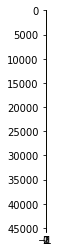

In [67]:
plt.figure()
plt.imshow(mapita)
plt.show()

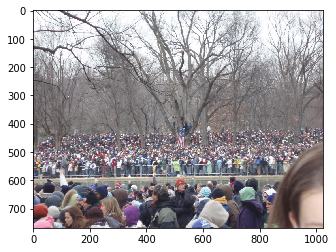

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
import imageio

imagen = "/media/daniel/Respaldo/Memoria/Pruebas/ShanghaiTech/part_A/train_data/images/IMG_1.jpg"
im = imageio.imread(imagen)
plt.imshow(im, cmap='Greys_r')

In [50]:
im.shape

(768, 1024, 3)

In [51]:
capa_1 = im[:,:,1]

In [53]:
np.max(capa_1),np.min(capa_1)

(255, 9)

In [21]:
h ="/media/daniel/Respaldo/Memoria/Pruebas/ShanghaiTech/part_A_final/train_data/ground_truth/IMG_1.h5"
import h5py
with h5py.File(h, 'r') as hf:
    d = hf['density'].value

/home/daniel/anaconda3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [22]:
imagen = '/media/daniel/Respaldo/Memoria/Pruebas/ShanghaiTech/part_A_final/train_data/images/IMG_1.jpg'
mat = io.loadmat(imagen.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
img= plt.imread(imagen)
gt = mat["image_info"][0,0][0,0][0]


In [23]:
mapa_densidad = utilidades.get_density_map_gaussian(gt,img.shape[1],img.shape[0],sigma = 4)

In [24]:
unique, counts = np.unique(mapa_densidad, return_counts=True)
unique

In [26]:
unique, counts = np.unique(d, return_counts=True)
unique

array([0.0000000e+00, 6.8233731e-11, 7.1198769e-11, ..., 2.1055812e-01,
       2.5477567e-01, 2.6347283e-01], dtype=float32)

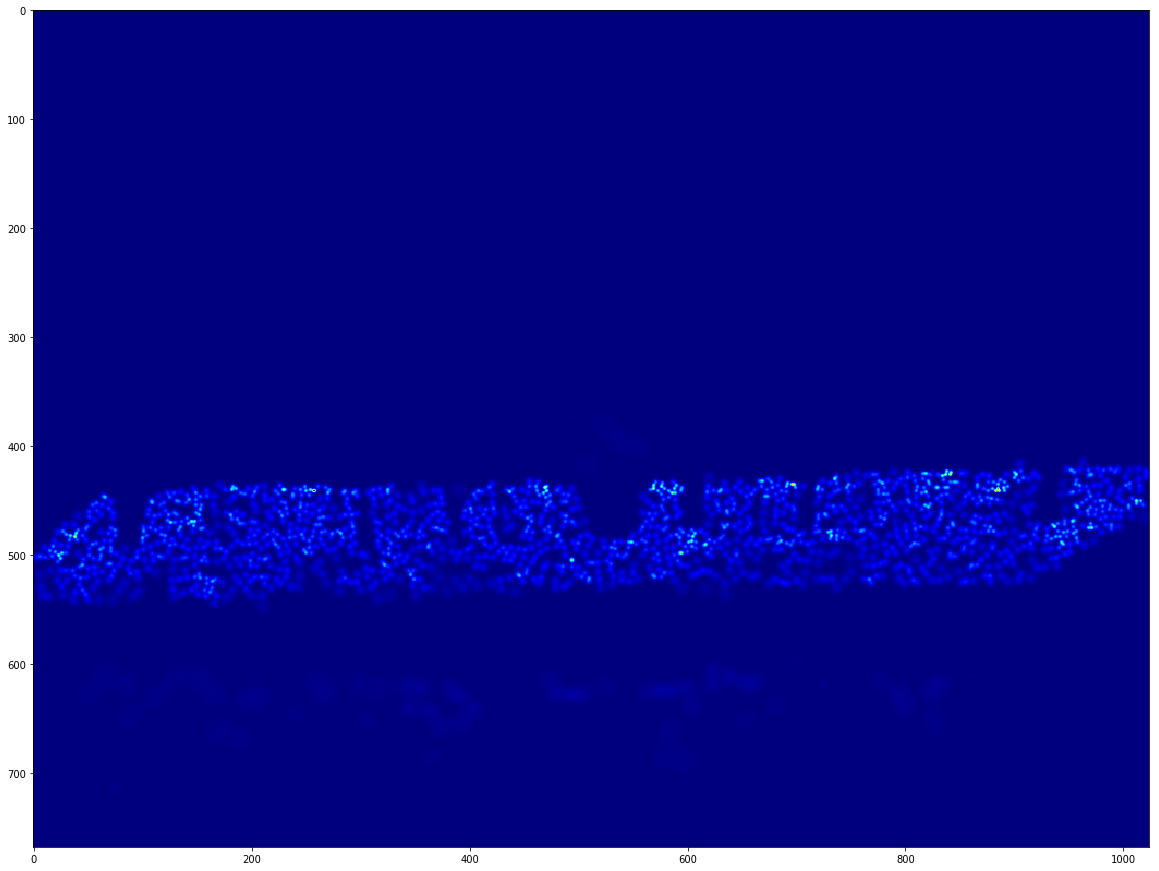

In [76]:
plt.figure(figsize=(20,20))
plt.imshow(d,cmap=CM.jet)
# plt.colorbar()
plt.show()

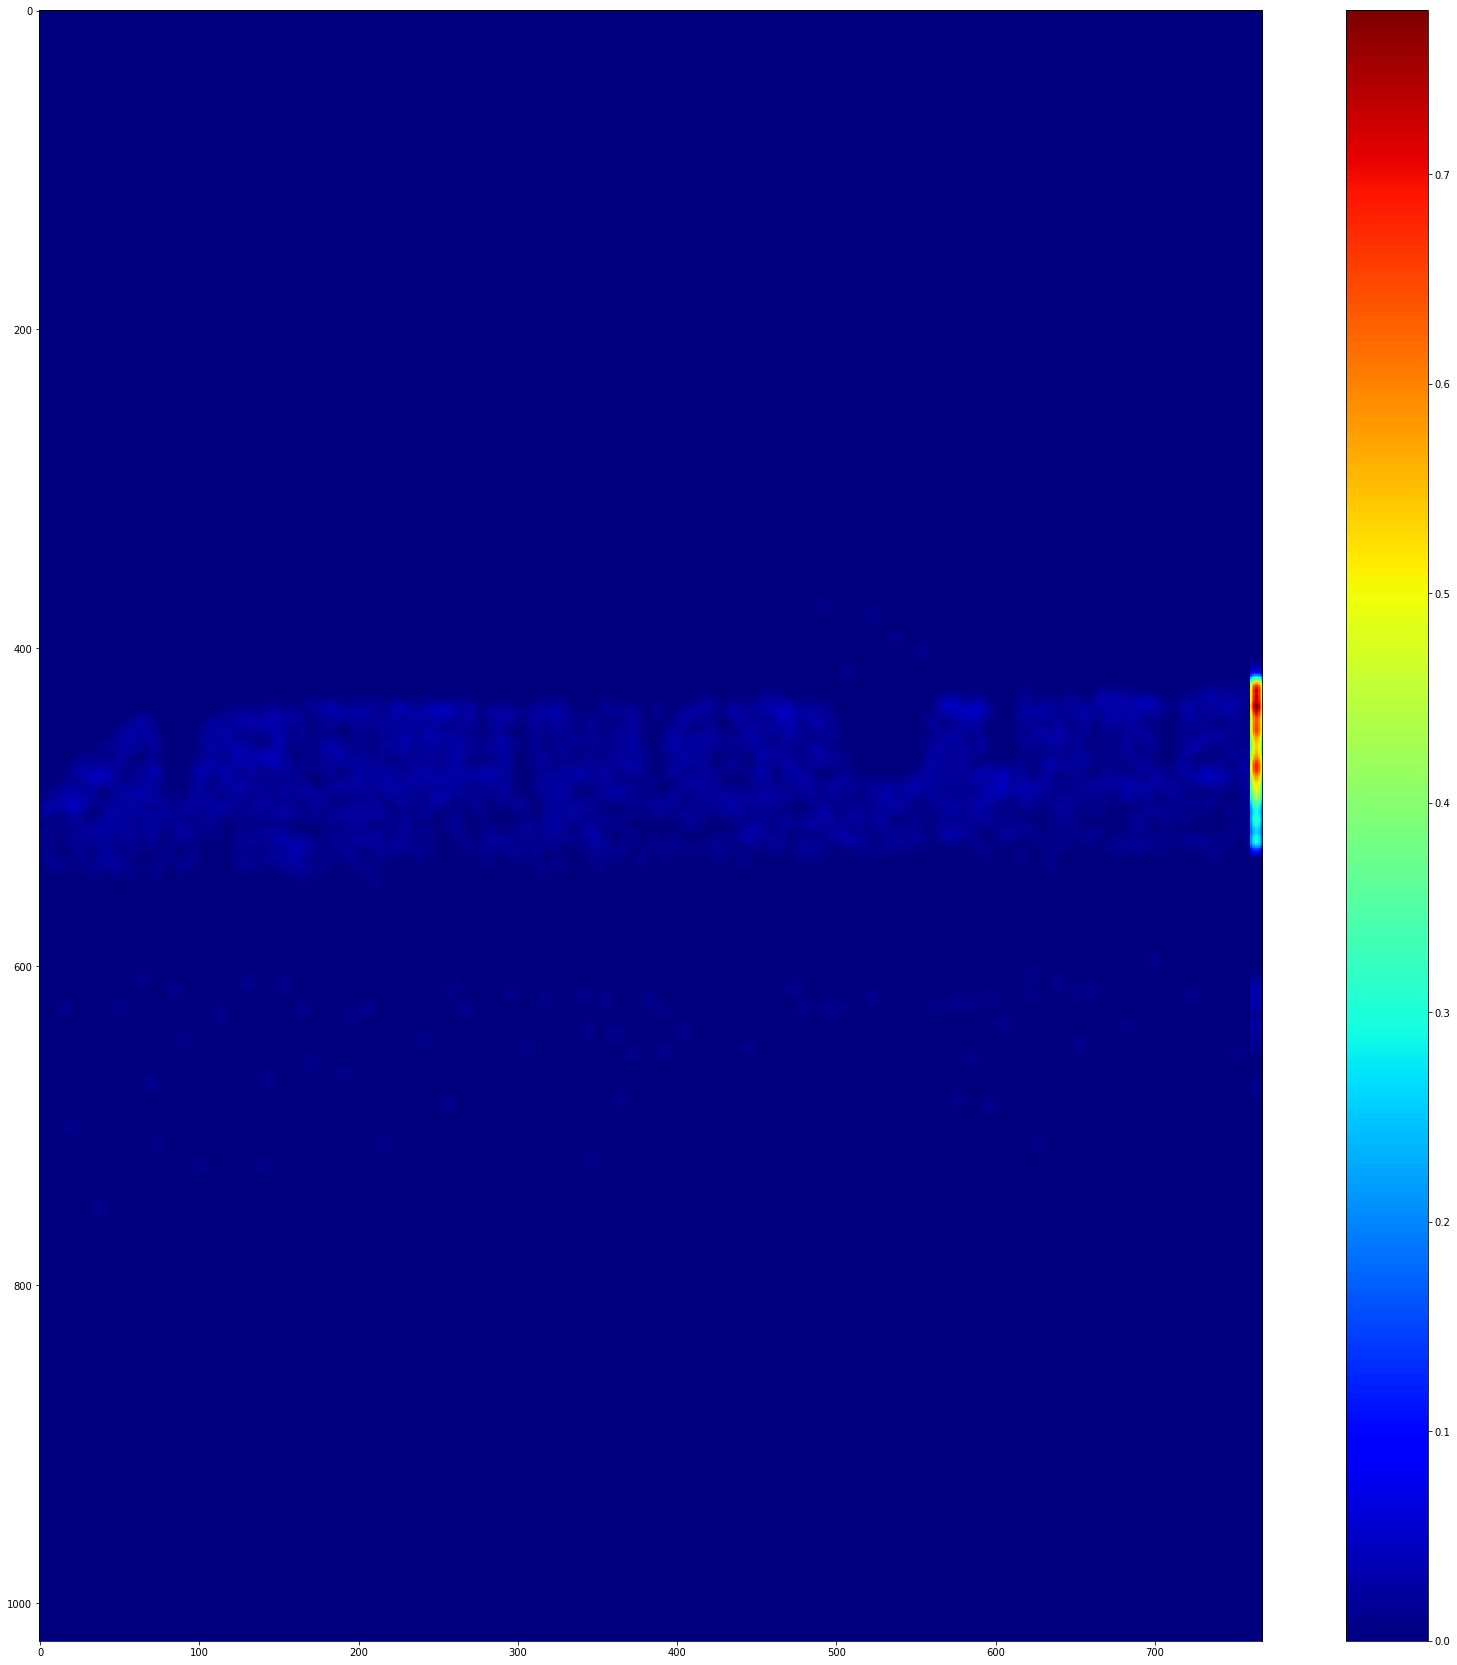

In [73]:
plt.figure(figsize=(30,30))
plt.imshow(mapa_densidad,cmap=CM.jet)
plt.colorbar()
plt.show()

In [74]:
np.sum(d),np.sum(mapa_densidad)

(1543.841, 1546.0004)